# Investigation of Gaussian Convolutions in N dimensional Space

Aims:
We propose a solution to the question of replay in the context of catastrophic forgetting. An attempt is made to create a 'net' to capture high-quallity 'reward' input vectors which contribute to learning. These vectors will be used in replay schemes.

For useful analysis to be made, there is a need for meaningful variation in input vector space. The current sampling technique uses a gaussian and thus forms an N dimensional sphere which is isotropic. This is not helpful for our analysis of finding high quality points. 

We attempt to 'mask' the gaussian using convolutions of other probability distributions. 

Examples include:
- Exponential
- Tent Function
- Uniform Dist (with skew)
- Parabolic

Import Libraries

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy as sp
import scipy.special
import random
import torch

In [22]:
rng = default_rng() #add this to config/__init__ if no random generator present already

### A short note on scaling:
We need to scale our values by the scale of the expected magnitude of a standard multivariate gaussian vector. 

Nish (@Nishil Patel on Slack) kindly provided the following code for scaling an N dimensional gaussian vector of variance=1. Notes are my own (Ariel).

Scaling our variance by any value other than 1 means we need to multiply our new magnitude (i.e. the new mean) by sqrt(new variance). 

In [3]:
def magnitude(n):
  if n % 2 == 0:
    a, b = n+1, n/2
    c = 1
    for i in range(int(n/2-1)):
      a, b = a-2, b-1
      c = c*a/(2*b)
    return np.sqrt(np.pi/2)*c #multiply by pi/2 due to the last remaining factor in the factorial multiplication being even i.e. n=2
  else:
    a, b = (n+1)/2, n
    c = 1
    for i in range(int((n-1)/2)):
      a, b = a-1, b-2
      c = c*2*a/b
    return np.sqrt(2/np.pi)*c #last factor in factorial is n=1, which has a gamma function value of sqrt(2/pi)

#for reference, look at https://stats.stackexchange.com/questions/167133/expected-magnitude-of-a-vector-from-a-multivariate-normal


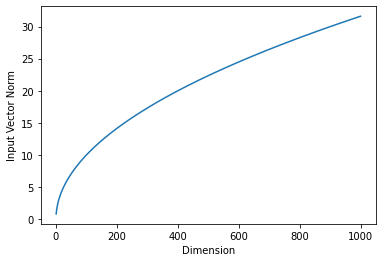

In [6]:
#visualise dimensionality and scale

n = np.arange(1, 1000, 1)
y = [magnitude(_) for _ in n]

plt.plot(n, y)
#plt.grid()
plt.ylabel('Input Vector Norm')
plt.xlabel('Dimension')
plt.show()

### Test for exponential convolved with gaussian.

In [1]:
#analytic solution of Ex-Gauss dist:
def convolve_exp_norm(gamma, mu=0, sigma, tau=0, x):
    """
    Parameters:
    gamma = index of exponential
    mu = mean of the Gaussian (i.e. the centroid). If none-zero it is an offset
    sigma = std of normal distribution
    x = input value
    tau = pdf offset


    """
    co = (gamma/2.0) * np.exp( gamma*mu+ gamma*gamma*sigma*sigma/2.0)
    x_erf = (mu + gamma*sigma*sigma - x - tau)/(np.sqrt(2.0)*sigma)
    y = co * np.exp(-gamma*(x + tau)) * (1.0 - scipy.special.erf(x_erf))
    return y

def exGauss_scaling(x, sigma, gamma):
    """
    x = input vector (array)
    sigma = std of gaussian
    gamma = index of exponential
    """
    varNew = sigma*2 + 1/gamma*gamma
    sigmaNew = np.sqrt(varNew)
    y = sigmaNew*x
    return y
# Randomly sample parameters
# Debate between using gaussian vs uniform random dist for parameter sampling. This affects our scaling!
# I am not sure (as of yet) how to apply the scaling to our problem. Pretty sure we just multiply each sample component
# of the input vector by the new scale, but I could be wrong

Using a gaussian to randomly sample the parameter values for the convolution will make sure our input distributions are mostly similar and we can highlight the rare events. However, using a uniform dist will allow us to have an unbiased view of which inputs are best...

In [ ]:
#test convolution
x = np.arange(-5.0,5.0,0.1)
gamma = 1.0 # index of the exponential function
sigma = 0.5 # dispersion of the normal distribution
mu = 0 # center of the normal distribution
tau = -0.5 # offset of exponential

In [ ]:
#uniform dist
def uniform_params(varChange = False, muChange = False):
    if muChange:
        mu = rng.uniform(-3, 3)
    else:
        mu = 0.0
    if varChange:
        sigma = rng.uniform(0.5, 1.5)
    tau = rng.uniform(-3*sigma-abs(mu), 3*sigma+abs(mu))
    gamma = rng.random()
    return gamma, mu, sigma, tau
    
#for gaussian dist use rng.multivariate_normal